# Emotion Analysis in Tweets 
by Jesse Elliott and Alina Gonzalez

#### Our data 
For this project we utilized [this](https://github.com/dair-ai/emotion_dataset) dataset with sampled tweets + preprocessed emotions as labels. 

__The labels were as provided:__
Anger : 0
Fear : 1
Joy : 2
Love : 3
Sadness : 4
Surprise : 5

### All imports & Constants

In [1]:
import pandas as pd
import numpy as np 
from collections import Counter 
import math 
import random 
import time 
from utils import LanguageModel 
from tqdm.notebook import tqdm 
import json

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pickle

SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
UNK = "<UNK>"
EMOTION_KEY = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5: 'surprise'} # manually done 

### Initial Analysis

In [2]:
df = pd.read_csv('data/training.csv')
df['label_text'] = [EMOTION_KEY[_] for _ in df['label']]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,anger
1,i can go from feeling so hopeless to so damned...,0,anger
2,im grabbing a minute to post i feel greedy wrong,3,love
3,i am ever feeling nostalgic about the fireplac...,2,joy
4,i am feeling grouchy,3,love


In [3]:
# write the data frame to .txt file 
path = 'data/training.txt'

with open(path, 'w') as file: 
    for line in list(df['text']): 
        file.write(line + '\n')

In [4]:
px.histogram(df["label_text"]) # everyone is afraid i guess

##### Balancing the data

We came to the conclusion that we needed to balance the data in order to prevent our model from underperforming with certain emotions. 

In [5]:
# Determine the number of data points for the 'fear' class
fear_count = df[df['label'] == 1].shape[0]

# Get the data points for each emotion class with the same count as 'fear'
balanced_data = pd.concat([df[df['label'] == label].sample(fear_count, replace=True, random_state=42) 
                           for label in range(6)])

# Save the balanced data to a new CSV file
balanced_data.to_csv('data/balanced_data.csv', index=False)

In [6]:
# write the data frame to .txt file 
path = 'data/balanced_training.txt'

with open(path, 'w') as file: 
    for line in list(balanced_data['text']): 
        file.write(line + '\n')

In [7]:
px.histogram(balanced_data["label_text"]) # thats better

##### Exploring the data! 

We want to understand what words define an emotion! Lets make a word cloud to get a visual representation of just that! 

In [8]:
def parse(lst:list, stopwords):
    """ parses a list of strings representing tweets """ 
    valid_total = []
    for tweet in lst: 
        tweet = tweet.split()
        valid = [word for word in tweet if word not in stopwords]
        valid_total.append(" ".join(valid))
    return " ".join(valid_total)

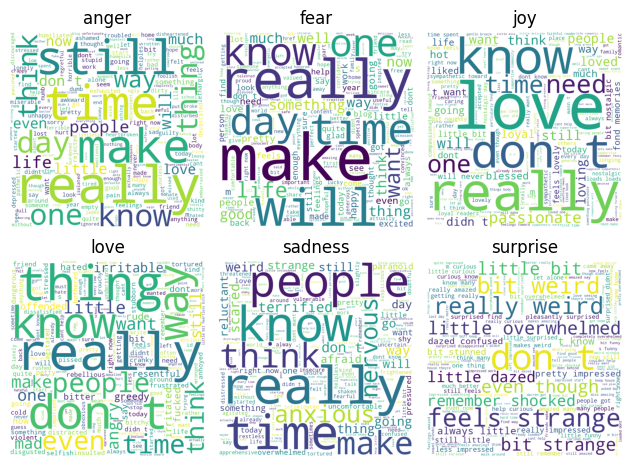

In [9]:
stopwords = set(list(STOPWORDS) + ['feel', 'feeling', 'ive', 'im'])

# generate a word cloud for every... label
for label in EMOTION_KEY.keys(): 
    sub_df = balanced_data.loc[balanced_data['label'] == label] # gets only values with this specific label 
    text = parse(sub_df['text'].tolist(), stopwords)
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
    # plot the WordCloud image  
    plt.subplot(2, 3, label+1)     
    plt.title(EMOTION_KEY[label])                
    # plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 1)
    
plt.show()

### Model Training and Evaluation 

In [10]:
train = pd.read_csv('data/balanced_data.csv')
test = pd.read_csv('data/test.csv')
valid = pd.read_csv('data/validation.csv')

EMOTION_KEY = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5: 'surprise'}
train['label_text'] = train['label'].map(EMOTION_KEY)
test['label_text'] = test['label'].map(EMOTION_KEY)
valid['label_text'] = valid['label'].map(EMOTION_KEY)

In [12]:
# tokenize text into sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'])
train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])
valid_sequences = tokenizer.texts_to_sequences(valid['text'])

In [48]:
print(f'Vocab size: {len(train['text'].unique())}')

Vocab size: 12032


In [13]:
# pad the text sequences
max_length = max([len(seq) for seq in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

#### Models: 

In [14]:

# a simple feed-forward neural network using sequential dense layers
def simple_ffn(input_shape, output_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(output_shape, activation='softmax')
    ])

    return model

# a recurrent neural network model
def rnn_model(input_shape, output_shape):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=input_shape),
        LSTM(64),
        Dense(output_shape, activation='softmax')
    ])

    return model

# a convolutional neural network model
def cnn_model(input_shape, output_shape):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(output_shape, activation='softmax')
    ])

    return model

#### Training: 

In [15]:
# func to train the model and output evaluation of training based on the history
def train_and_evaluate(model, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, train_labels, epochs=10, validation_data=(valid_data, valid_labels), verbose=2)
    loss, accuracy = model.evaluate(test_data, test_labels, verbose=2)
    return history, loss, accuracy

In [16]:
X_train, y_train = train_padded, train['label'].values
X_test, y_test = test_padded, test['label'].values
X_valid, y_valid = valid_padded, valid['label'].values

In [17]:
input_shape = X_train.shape[1:]
output_shape = len(train['label'].unique())
ffn_model = simple_ffn(input_shape, output_shape)
ffn_history, ffn_loss, ffn_accuracy = train_and_evaluate(ffn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

Epoch 1/10
1006/1006 - 1s - 1ms/step - accuracy: 0.1854 - loss: 157.5505 - val_accuracy: 0.2160 - val_loss: 60.7685
Epoch 2/10
1006/1006 - 1s - 637us/step - accuracy: 0.2188 - loss: 40.7051 - val_accuracy: 0.1510 - val_loss: 32.2032
Epoch 3/10
1006/1006 - 1s - 648us/step - accuracy: 0.2320 - loss: 18.6176 - val_accuracy: 0.1810 - val_loss: 15.4778
Epoch 4/10
1006/1006 - 1s - 636us/step - accuracy: 0.2386 - loss: 10.0498 - val_accuracy: 0.1340 - val_loss: 11.4717
Epoch 5/10
1006/1006 - 1s - 642us/step - accuracy: 0.2388 - loss: 6.2126 - val_accuracy: 0.1725 - val_loss: 5.5188
Epoch 6/10
1006/1006 - 1s - 658us/step - accuracy: 0.2368 - loss: 4.2639 - val_accuracy: 0.1280 - val_loss: 4.4270
Epoch 7/10
1006/1006 - 1s - 627us/step - accuracy: 0.2330 - loss: 3.0384 - val_accuracy: 0.1635 - val_loss: 2.9470
Epoch 8/10
1006/1006 - 1s - 622us/step - accuracy: 0.2228 - loss: 2.3579 - val_accuracy: 0.1335 - val_loss: 2.4390
Epoch 9/10
1006/1006 - 1s - 646us/step - accuracy: 0.2323 - loss: 2.0104 

In [18]:
rnn_input_shape = X_train.shape[1]
rnn_model = rnn_model(rnn_input_shape, output_shape)
rnn_history, rnn_loss, rnn_accuracy = train_and_evaluate(rnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

Epoch 1/10
1006/1006 - 17s - 17ms/step - accuracy: 0.1678 - loss: 1.7925 - val_accuracy: 0.2750 - val_loss: 1.7678
Epoch 2/10
1006/1006 - 19s - 18ms/step - accuracy: 0.1680 - loss: 1.7914 - val_accuracy: 0.2845 - val_loss: 1.7722
Epoch 3/10
1006/1006 - 19s - 19ms/step - accuracy: 0.1662 - loss: 1.7957 - val_accuracy: 0.1375 - val_loss: 1.8350
Epoch 4/10
1006/1006 - 18s - 18ms/step - accuracy: 0.1699 - loss: 1.7936 - val_accuracy: 0.3520 - val_loss: 1.7763
Epoch 5/10
1006/1006 - 18s - 18ms/step - accuracy: 0.1674 - loss: 1.7936 - val_accuracy: 0.1060 - val_loss: 1.7979
Epoch 6/10
1006/1006 - 18s - 18ms/step - accuracy: 0.1663 - loss: 1.7933 - val_accuracy: 0.2750 - val_loss: 1.7786
Epoch 7/10
1006/1006 - 19s - 19ms/step - accuracy: 0.1666 - loss: 1.7927 - val_accuracy: 0.3520 - val_loss: 1.7866
Epoch 8/10
1006/1006 - 19s - 19ms/step - accuracy: 0.1633 - loss: 1.7927 - val_accuracy: 0.1375 - val_loss: 1.7851
Epoch 9/10
1006/1006 - 18s - 18ms/step - accuracy: 0.1662 - loss: 1.7923 - val_a

In [19]:
cnn_model = cnn_model(rnn_input_shape, output_shape)
cnn_history, cnn_loss, cnn_accuracy = train_and_evaluate(cnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test)

Epoch 1/10
1006/1006 - 5s - 5ms/step - accuracy: 0.7361 - loss: 0.7110 - val_accuracy: 0.8730 - val_loss: 0.3904
Epoch 2/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9791 - loss: 0.0737 - val_accuracy: 0.8830 - val_loss: 0.3925
Epoch 3/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9922 - loss: 0.0286 - val_accuracy: 0.8835 - val_loss: 0.4704
Epoch 4/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9952 - loss: 0.0181 - val_accuracy: 0.8805 - val_loss: 0.4938
Epoch 5/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9964 - loss: 0.0142 - val_accuracy: 0.8750 - val_loss: 0.5421
Epoch 6/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.8755 - val_loss: 0.6081
Epoch 7/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9973 - loss: 0.0108 - val_accuracy: 0.8785 - val_loss: 0.6361
Epoch 8/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9975 - loss: 0.0098 - val_accuracy: 0.8755 - val_loss: 0.7204
Epoch 9/10
1006/1006 - 4s - 4ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.8585 - 

In [20]:
print("Simple Feedforward Neural Network - Test Loss:", ffn_loss, "Test Accuracy:", ffn_accuracy)
print("RNN Model - Test Loss:", rnn_loss, "Test Accuracy:", rnn_accuracy)
print("CNN Model - Test Loss:", cnn_loss, "Test Accuracy:", cnn_accuracy)


Simple Feedforward Neural Network - Test Loss: 2.137720823287964 Test Accuracy: 0.1054999977350235
RNN Model - Test Loss: 1.679540753364563 Test Accuracy: 0.3140000104904175
CNN Model - Test Loss: 0.7644145488739014 Test Accuracy: 0.859499990940094


#### Visualization: 

In [32]:
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(model_name)
    plt.legend(loc='lower right')

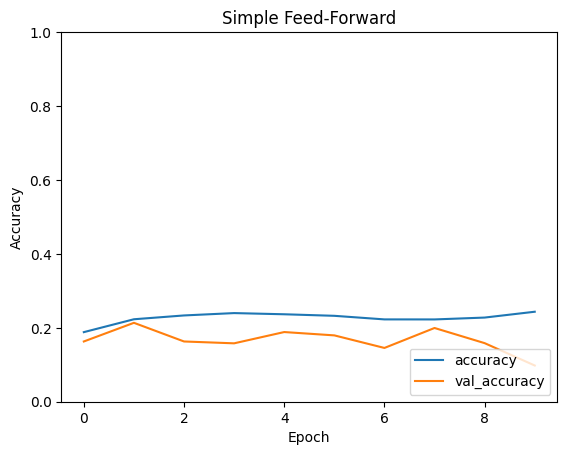

In [33]:
plot_history(ffn_history, 'Simple Feed-Forward')

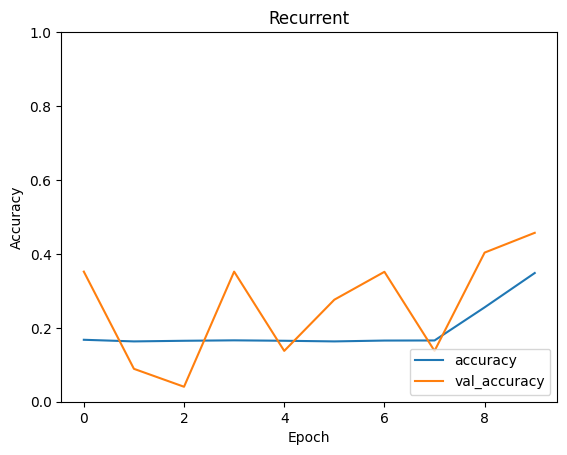

In [34]:
plot_history(rnn_history, 'Recurrent')

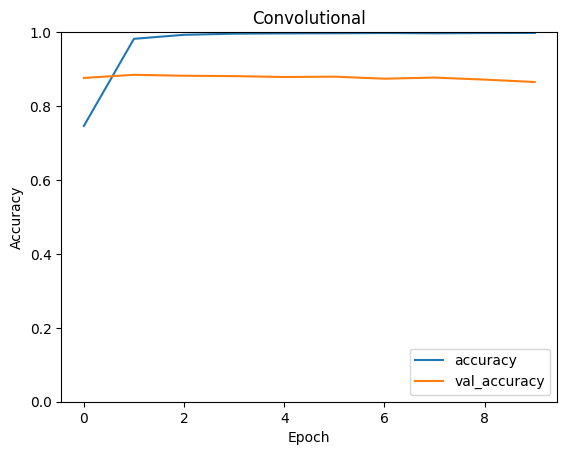

In [35]:
plot_history(cnn_history, 'Convolutional')

In [ ]:
ffn_model.save('saved_models/ffn_model.h5')
rnn_model.save('saved_models/rnn_model.h5')
cnn_model.save('saved_models/cnn_model.h5')

# save the tokenizer
with open('saved_models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
# prepare test data
X_test = tokenizer.texts_to_sequences(test['text'])
X_test = pad_sequences(X_test, maxlen=66, padding='post')
y_test = test['label'].values

# evaluate feed-forward neural network
ffn_loss, ffn_accuracy = ffn_model.evaluate(X_test, y_test, verbose=2)
print("Feed-Forward Neural Network - Test Loss:", ffn_loss, "Test Accuracy:", ffn_accuracy)

# evaluate recurrent neural network
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=2)
print("Recurrent Neural Network - Test Loss:", rnn_loss, "Test Accuracy:", rnn_accuracy)

# evaluate convolutional neural network
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=2)
print("Convolutional Neural Network - Test Loss:", cnn_loss, "Test Accuracy:", cnn_accuracy)


# generate predictions
ffn_probabilities = ffn_model.predict(X_test)
rnn_probabilities = rnn_model.predict(X_test)
cnn_probabilities = cnn_model.predict(X_test)

# convert probabilities to predicted classes
ffn_predictions = np.argmax(ffn_probabilities, axis=1)
rnn_predictions = np.argmax(rnn_probabilities, axis=1)
cnn_predictions = np.argmax(cnn_probabilities, axis=1)
# classification Report
print("Feed-Forward Neural Network Classification Report:")
print(classification_report(y_test, ffn_predictions))

print("Recurrent Neural Network Classification Report:")
print(classification_report(y_test, rnn_predictions))

print("Convolutional Neural Network Classification Report:")
print(classification_report(y_test, cnn_predictions))

# confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

63/63 - 0s - 737us/step - accuracy: 0.1055 - loss: 2.1377
Feed-Forward Neural Network - Test Loss: 2.137720823287964 Test Accuracy: 0.1054999977350235
63/63 - 0s - 5ms/step - accuracy: 0.3140 - loss: 1.6795
Recurrent Neural Network - Test Loss: 1.679540753364563 Test Accuracy: 0.3140000104904175
63/63 - 0s - 1ms/step - accuracy: 0.8595 - loss: 0.7644
Convolutional Neural Network - Test Loss: 0.7644145488739014 Test Accuracy: 0.859499990940094
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Feed-Forward Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.09      0.15       581
           1       0.41      0.09      0.14       695
           2       0.09      0.11      0.10       159
           3       0.14      0.08      0.10       275
           4       0.06      0.08      0.07       224
           5       0.04      0.59      0.07        66

   

c:\Users\alina\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\alina\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\alina\anaconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



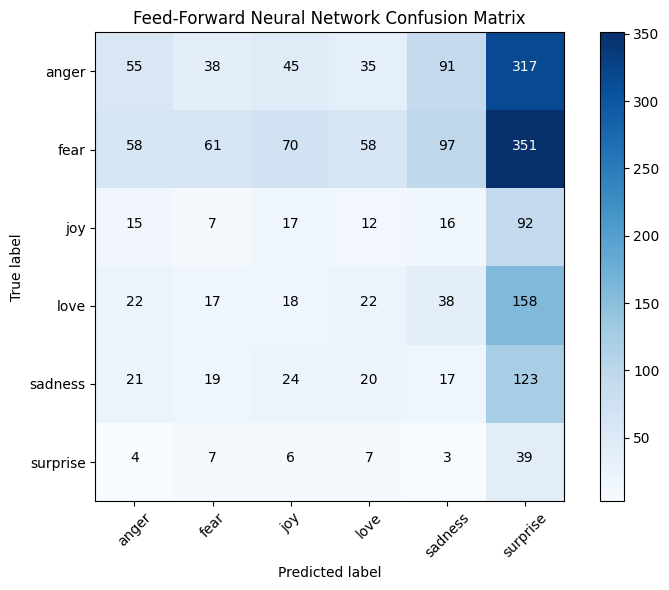

In [36]:
ffn_cm = confusion_matrix(y_test, ffn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(ffn_cm, classes=EMOTION_KEY.values(), title='Feed-Forward Neural Network Confusion Matrix')

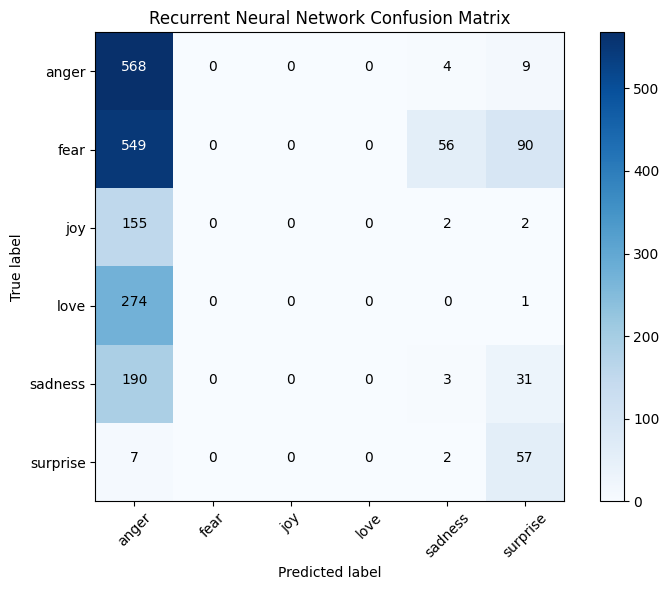

In [37]:
rnn_cm = confusion_matrix(y_test, rnn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(rnn_cm, classes=EMOTION_KEY.values(), title='Recurrent Neural Network Confusion Matrix')

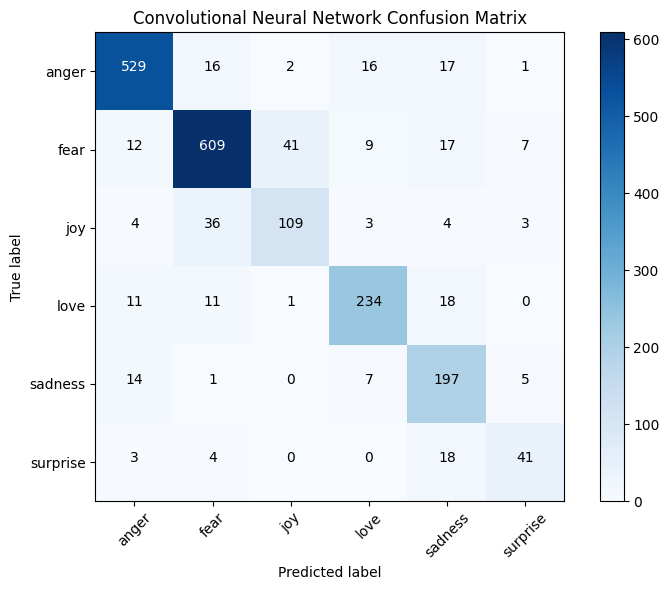

In [38]:
cnn_cm = confusion_matrix(y_test, cnn_predictions)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnn_cm, classes=EMOTION_KEY.values(), title='Convolutional Neural Network Confusion Matrix')

### Vanilla Bi-gram Model
We want to explore how the different neural networks and different emotions compare ot a simple vanilla bigram model. 

##### Util funcs: 

In [ ]:
def create_ngrams(tokens: list, n: int) -> list:
  """Creates n-grams for the given token sequence.
  Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

  Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
  """
  lst = []
  for i in range(len(tokens)): 
    ngrams = []
    for j in range(i, i+n): 
      try: 
        ngrams.append(tokens[j])
      except: 
        break
    if len(ngrams) == n: 
      lst.append(tuple(ngrams))
  return lst 

In [ ]:
def tokenize_line(line: str, ngram: int, 
                   by_char: bool = True, 
                   sentence_begin: str=SENTENCE_BEGIN, 
                   sentence_end: str=SENTENCE_END):
  """
  Tokenize a single string. Glue on the appropriate number of 
  sentence begin tokens and sentence end tokens (ngram - 1), except
  for the case when ngram == 1, when there will be one sentence begin
  and one sentence end token.
  Args:
    line (str): text to tokenize
    ngram (int): ngram preparation number
    by_char (bool): default value True, if True, tokenize by character, if
      False, tokenize by whitespace
    sentence_begin (str): sentence begin token value
    sentence_end (str): sentence end token value

  Returns:
    list of strings - a single line tokenized
  """
  inner_pieces = None
  if by_char:
    inner_pieces = list(line)
  else:
    # otherwise split on white space
    inner_pieces = line.split()

  if ngram == 1:
    tokens = [sentence_begin] + inner_pieces + [sentence_end]
  else:
    tokens = ([sentence_begin] * (ngram - 1)) + inner_pieces + ([sentence_end] * (ngram - 1))
  # always count the unigrams
  return tokens

In [ ]:
def tokenize(data: list, ngram: int, 
                   by_char: bool = True, 
                   sentence_begin: str=SENTENCE_BEGIN, 
                   sentence_end: str=SENTENCE_END):
  """
  Tokenize each line in a list of strings. Glue on the appropriate number of 
  sentence begin tokens and sentence end tokens (ngram - 1), except
  for the case when ngram == 1, when there will be one sentence begin
  and one sentence end token.
  Args:
    data (list): list of strings to tokenize
    ngram (int): ngram preparation number
    by_char (bool): default value True, if True, tokenize by character, if
      False, tokenize by whitespace
    sentence_begin (str): sentence begin token value
    sentence_end (str): sentence end token value

  Returns:
    list of strings - all lines tokenized as one large list
  """
  total = []
  # also glue on sentence begin and end items
  for line in data:
    line = line.strip()
    # skip empty lines
    if len(line) == 0:
      continue
    tokens = tokenize_line(line, ngram, by_char, sentence_begin, sentence_end)
    total += tokens
  return total

In [ ]:
text = []
with open('data/balanced_training.txt', 'r') as file: 
    for line in file: 
        text.append(line.strip())

##### Training and generating: 

In [ ]:
# reading data
df = pd.read_csv('data/balanced_data.csv')

emotion_dfs = {}
for label in EMOTION_KEY: 
    curr = df.loc[df['label'] == label]
    emotion_dfs[label] = curr
df.head()

In [ ]:
# ngram = 2
# gen_sents = {}
# for label, df_ in tqdm(emotion_dfs.items()): 
#     # tokenize by word
#     toks = tokenize(list(df_['text']), ngram, by_char=False)
#     lm = LanguageModel(ngram)
#     lm.train(toks)
#     gen_sents[label] = lm.generate(1000)

In [ ]:
# with open('vanilla_emotion_results.txt', 'w') as file: 
#     json.dump(gen_sents, file)

### Testing Bigrams!

In [39]:
# load the generated bigram sequences
with open('vanilla_emotion_results.txt', 'r') as file:
    bigram_gen = json.load(file)

In [40]:
# convert the generated sentences into the specified format
formatted_sentences = []
for emotion, sentences in bigram_gen.items():
    for sentence in sentences:
        # remove beginning and end sentence tokens
        sentence = [token for token in sentence if token not in ['<s>', '</s>']]
        formatted_sentence = ' '.join(sentence)
        formatted_sentences.append({'text': formatted_sentence, 'label': emotion})

# create a DataFrame from the formatted sentences
formatted_df = pd.DataFrame(formatted_sentences)

# save the DataFrame to a CSV file
formatted_df.to_csv('formatted_generated_sentences.csv', index=False)

In [41]:
bigen = pd.read_csv("formatted_generated_sentences.csv")
X_bigen = tokenizer.texts_to_sequences(bigen['text'])
X_bigen = pad_sequences(X_bigen, maxlen=66, padding='post')
y_bigen = bigen['label'].values

In [47]:
ffnloss, ffnaccuracy = ffn_model.evaluate(X_bigen, y_bigen, verbose=2)

188/188 - 0s - 618us/step - accuracy: 0.1667 - loss: 3.2372


In [46]:
rnnloss, rnnaccuracy = rnn_model.evaluate(X_bigen, y_bigen, verbose=2)

188/188 - 1s - 5ms/step - accuracy: 0.1687 - loss: 1.9265


In [45]:
cnnloss, cnnaccuracy = cnn_model.evaluate(X_bigen, y_bigen, verbose=2)

188/188 - 0s - 1ms/step - accuracy: 0.1645 - loss: 11.1850
